<a href="https://colab.research.google.com/github/jdasam/mas1004-2023/blob/main/assignment_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Coding Assignment 3
- In this assignment you have to train a simple matrix factorization model for Small MovieLens dataset 
- The goal of this assignment is to have an experience on what kind of information does recommendation system learns from data
- 84 pts for running the given code and analyze the result just by changing some numbers
- 16 pts for completing the given function
- You have to submit a report and a code
  1. A Report in free format (submit in PDF)
    - Your setting about how you trained the model
    - Your answer and explanation on 7 problems
      - Including the Problem 6 and 7 (programming problems)
    - Your submission would be evalulated mainly with the report
    - Please include the screen capture of table and visualization in your report
  2. Code (submit in ipynb)
- You don't have to use GPU for this assignment. I recommend you not to use hardware acceleartor on Colab


# 0. Import Library and Download data

In [ ]:
!wget https://files.grouplens.org/datasets/movielens/ml-latest-small.zip
!unzip ml-latest-small.zip

### Import libraries and functions

In [ ]:
from tqdm.auto import tqdm
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

class RatingSet:
  def __init__(self, csv_path='ml-latest-small/ratings.csv'):
    self.ratings = pd.read_csv(csv_path)

    # how many unique users exist in this dataset
    self.n_users = len(set(self.ratings['userId']))
    self.n_movies = len(set(self.ratings['movieId']))

    # list the every ids of included users
    self.user_ids = list(set(self.ratings['userId']))
    self.movie_ids = sorted(list(set(self.ratings['movieId'])))

    # we have to find in which idx the given movieId exists in this dataset's movie ID
    self.movie2idx = {id: idx for idx, id in enumerate(self.movie_ids)}
    self.user2idx = {id: idx for idx, id in enumerate(self.user_ids)}

  def __len__(self):
    return len(self.ratings) # number of ratings in the dataset

  def __getitem__(self, idx):
    idx_row = self.ratings.iloc[idx]

    user_id = self.user2idx[idx_row.userId]
    movie_id = self.movie2idx[idx_row.movieId]
    rating = idx_row.rating

    return user_id, movie_id, torch.tensor(rating, dtype=torch.float32)

class MatrixFactorizer(nn.Module):
  def __init__(self, n_user, n_movie, n_factor):
    super().__init__()

    self.user_embedding = nn.Embedding(n_user, n_factor)
    self.movie_embedding = nn.Embedding(n_movie, n_factor)

    self.user_embedding.weight.data /= n_factor ** 0.5
    self.movie_embedding.weight.data /= n_factor ** 0.5

    self.scale = 5.5

  def scaled_sigmoid(self, x):
    return 1/(1+torch.exp(-x/self.scale)) * self.scale
  
  def forward(self, user_id, movie_id):
    user_emb_vec = self.user_embedding(user_id)
    movie_emb_vec = self.movie_embedding(movie_id)

    dot_prod_result = torch.einsum('ij,ij->i', user_emb_vec, movie_emb_vec)
    return self.scaled_sigmoid(dot_prod_result)



class MatrixFactorizerWithBias(MatrixFactorizer):
  def __init__(self, n_user, n_movie, n_factor):
    super().__init__(n_user, n_movie, n_factor)
    self.user_bias = nn.Embedding(n_user, 1)
    self.movie_bias = nn.Embedding(n_movie, 1)
    self.user_bias.weight.data = torch.zeros(n_user, 1)
    self.movie_bias.weight.data = torch.zeros(n_movie, 1)
  

  def forward(self, user_id, movie_id):
    user_emb_vec = self.user_embedding(user_id)
    movie_emb_vec = self.movie_embedding(movie_id)

    dot_prod_result = torch.einsum('ij,ij->i', user_emb_vec, movie_emb_vec)
    dot_prod_result += self.user_bias(user_id)[:, 0] + self.movie_bias(movie_id)[:, 0]

    return self.scaled_sigmoid(dot_prod_result)

class Trainer:
  def __init__(self, model, train_loader, valid_loader, model_name='movielens', device='cpu'):
    self.model = model
    self.train_loader = train_loader
    self.valid_loader = valid_loader
    self.device = device
    self.model.to(self.device)
    self.criterion = nn.MSELoss()
    self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-3)
    self.acc_threshold = 0.5
    self.best_loss = torch.inf
    self.best_acc = 0.0
    self.train_losses = []
    self.valid_losses = []
    self.train_accs = []
    self.valid_accs = []
    self.model_name = model_name

  def validation(self):
    self.model.eval() # change the model from train mode to evaluation mode
    # Some models work in different ways based on whtehter it is on training step
    # or on inference step

    # In validation step, you don't have to calculate the gradient
    # with torch.no_grad():

    current_loss = 0
    num_total_correct_pred = 0
    with torch.inference_mode(): # every torch computation under this indent
    # will be run without calculating the gradient or computation history
      for batch in self.valid_loader:
        user_ids, movie_ids, ratings = batch
        user_ids, movie_ids, ratings = user_ids.to(self.device), movie_ids.to(self.device), ratings.to(self.device)

        self.optimizer.zero_grad()
        outputs = self.model(user_ids, movie_ids) 

        loss = self.criterion(outputs, ratings) # you have to feed log_probs

        num_acc_pred = (torch.abs(outputs - ratings) < self.acc_threshold).sum()

        num_total_correct_pred += num_acc_pred.item()
        # in validation stage, we don't care about single batch's loss
        # we want to see the result for total images of validation set

        current_loss += loss.item() * len(ratings)
        # instead of adding the mean loss, we add sum of loss
        # because the batch size can be different
    mean_loss = current_loss / len(self.valid_loader.dataset)
    mean_acc = num_total_correct_pred / len(self.valid_loader.dataset) # number of total datasample in the validation loader
    return mean_loss, mean_acc
    # return {'loss': mean_loss, 'acc': mean_acc}



  def train_by_number_of_epochs(self, num_epochs):
    for epoch in tqdm(range(num_epochs)):
      self.model.train()
      for batch in tqdm(self.train_loader, leave=False):
        user_ids, movie_ids, ratings = batch
        user_ids, movie_ids, ratings = user_ids.to(self.device), movie_ids.to(self.device), ratings.to(self.device)
        self.optimizer.zero_grad()
        outputs = self.model(user_ids, movie_ids) 

        loss = self.criterion(outputs, ratings) # you have to feed log_probs

        acc = (torch.abs(outputs - ratings) < self.acc_threshold).sum() / len(ratings)
        # for torch.nn.NLLLoss
        loss.backward()
        self.optimizer.step()

        self.train_losses.append(loss.item())
        self.train_accs.append(acc.item())
        # don't try self.train_losses.append(loss)
        # because loss is a torch.tensor object
        
      # training step has ended
      # we want to test our model on the validation set
      valid_loss, valid_acc = self.validation()

      # is this model the best? 
      # let's decide it based on valid_acc
      if valid_acc > self.best_acc:
        self.best_acc = valid_acc

        # If it is the best model, save the model's weight'
        models_parameters = self.model.state_dict()
        print(f"Saving best model at epoch {len(self.valid_accs)}, acc: {valid_acc}")
        torch.save(models_parameters, f'{self.model_name}_best.pt')

      self.valid_losses.append(valid_loss)
      self.valid_accs.append(valid_acc)

    # Plot Accuracy curve
    plt.plot(self.train_accs)
    plt.plot(range(len(self.train_loader)-1, len(self.train_accs), len(self.train_loader)) ,self.valid_accs)
    plt.title("Accuracy")

## Prepare Data Split and DataLoader 

In [ ]:
movies = pd.read_csv('ml-latest-small/movies.csv')
ratings = pd.read_csv('ml-latest-small/ratings.csv')

movies = movies[movies['movieId'].isin(ratings['movieId'])]
movies.reset_index(drop=True, inplace=True)
movies['title'].to_csv("list_of_movie_titles.csv")

dataset = RatingSet()
num_train = int(len(dataset)*0.9)
num_valid = int(len(dataset)*0.05)
num_test = len(dataset) - num_train - num_valid
train_set, valid_set, test_set = torch.utils.data.random_split(dataset, 
                                              [num_train, num_valid, num_test],
                                               generator=torch.Generator().manual_seed(0))
train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True, num_workers=2)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=512, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=512, shuffle=False)

## Problem 0. Train Embeddings
- You can train your model by selecting proper `n_factors` and `n_epoch`
- **IMPORTANT about Report:** You have to explain your hyperparameters for training the model
  - `n_factors`
  - `n_epoch`
  - Why did you choose those specific values?
- **You have to select proper n_factors and n_epoch**
  - If you choose reasonable hyperparameters, you will get more than **0.4 validation accuracy**
- For default value, you can use `n_factors=50` and `n_epoch=7`

In [ ]:
# TODO: Select Proper Hyperparameters, n_factors and n_epoch
n_factors = 50
n_epoch = 7

model = MatrixFactorizerWithBias(dataset.n_users, dataset.n_movies, n_factors)
trainer = Trainer(model, train_loader, valid_loader, device='cuda')
trainer.train_by_number_of_epochs(n_epoch)


### Select the model based on validation loss
- The training code saves model parameters for every epoch
- Based on your criteria, you can select the model by epoch
  - If you want to load the Epoch 10 version, run `model.load_state_dict(model_states[10])`

In [ ]:
model.load_state_dict(torch.load('movielens_best.pt'))
movie_embs = model.movie_embedding.weight.detach().cpu()
movie_bias = model.movie_bias.weight.detach().cpu()

## Problem 1: Analyze Bias of Movie Embedding: Why do we use Bias?
- Explain why some films have high bias and some films have low bias
  - Explain the commonality between films with high bias
  - Explain the commonality between films with low bias
  - Explain why is using bias helps to make a recommendation system
- Following code will show the title of movie by descending order of bias

In [ ]:
indices = torch.argsort(movie_bias.squeeze(), descending=True)
indices = indices.tolist()
pd.set_option('display.min_rows', 20) # you can set number of print rows by this line
pd.DataFrame({"title": list(movies['title'].iloc[indices]), "bias": movie_bias[indices].squeeze().tolist()})

## Problem 2: Similarity Search
- Try to find the most similar movies and least similar movies for a given movie
- Explain whether the searched result makes sense to you or not
- In report, **explain at least 3 examples of your choice**
- The following code will print out the movies based on their similarities to a selected movie
  - Similarities are calculated based on movie embeddings with cosine similarity
- You can search the id of movies from `list_of_movie_titles.csv` that is uploaded in Cyber Campus

In [ ]:
def get_cosine_sim(emb, embs):
  with torch.no_grad():
    return torch.sum(emb * embs, dim=1) / (torch.sum(emb**2) * torch.sum(embs**2, dim=-1)) ** 0.5

In [ ]:
movie_embs = model.movie_embedding.weight.cpu()
sel_movie_id = 5682 # Select the desired movie ID from list_of_movie_titles.csv

sims = get_cosine_sim(movie_embs[sel_movie_id], movie_embs)
sims[sel_movie_id]=0
_, indices = torch.sort(sims, descending=True)
indices = indices.tolist()
print(f"Titles of selected movie_id is: {movies.iloc[sel_movie_id]['title']}")
pd.DataFrame({"title":list(movies['title'].iloc[indices]), "genre":list(movies['genres'].iloc[indices]), "similarity": sims[indices].tolist()})

## Problem 3: Embedding Visualization
- **Navigate through the visualization and discover interesting informations from the embeddings**
  - For examples,
    - Which movies are making a cluster?
      - Are the movies in a cluster looks similar to you?
    - Which movies are located far away?
- **Explain how your model could learn such similarities based only on the user's ratings**
- You can use both 2D plot and 3D plot, or just select one to work with based on your preference
  - I recommend you to use 2D plot for discovering local cluster, and 3D plot for global view

- **You have to attach the screen capture of each cluster**
- The code below will make UMAP transformation of the given trained movie embeddings
  - Regardless of what factor you selected for the matrix factorization, UMAP can reduce the dimension of embedding to 2D or 3D
  - UMAP is one of machine learning algorithms for reducing data dimension, and it is a very good tool for making data visualization
  - During the dimension reduction, UMAP tries to the preserve local neighbor distance and also the global distance
  - Movies with similar embeddings will be located closely to each other in the UMAP embeddings
  - For the detailed explanation about what is UMAP, please refer this [YouTube video](https://youtu.be/6BPl81wGGP8)


### 0: Install and Import Library, Setup pre-defined functions

In [ ]:
!pip install -q umap-learn
!pip install -Uq plotly

In [ ]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import umap
import plotly
import plotly.graph_objs as go
plotly.offline.init_notebook_mode()

def get_umap_embedding(embedding, n_reduced_dimension=2, n_neighbors=15):
  reducer = umap.UMAP(n_components=n_reduced_dimension, n_neighbors=n_neighbors)
  umap_emb = reducer.fit_transform(embedding)
  return umap_emb

def make_scatter3d(emb, label):
  trace = go.Scatter3d(
    x=emb[:,0],  
    y=emb[:,1],  
    z=emb[:,2], 
    mode='markers',
    marker={
        'size': 2,
        'opacity': 0.5,
    },
    text = label,
  )
  return trace

def make_3d_plot_with_pyplot(embs, labels, highlighted_titles):
  highlighted_indices = [labels.index(title) if title in labels else 0 for title in highlighted_titles]
  layout = go.Layout(
      margin={'l': 0, 'r': 0, 'b': 0, 't': 0},
      scene=dict(
          annotations = [dict(x=embs[i,0], y=embs[i,1], z=embs[i,2],text=labels[i]) for i in highlighted_indices ]
      )
  )
  data = make_scatter3d(embs,labels)
  plot_figure = go.Figure(data=data, layout=layout)
  plot_figure.update_traces(textposition='top center')
  plot_figure.show(renderer='colab')
  


### 3-1 Make Embeddings
- `n_neighbors` is a hyperparameter of UMAP. If you use larger n_neighbors, UMAP will consider more neighbors for each item

In [ ]:
movie_embs_np = movie_embs.detach().numpy()

embs_2d = get_umap_embedding(movie_embs_np, n_reduced_dimension=2, n_neighbors=15)
embs_3d = get_umap_embedding(movie_embs_np, n_reduced_dimension=3, n_neighbors=15)

- Following code will make simple static PLT plot

In [ ]:
plt.scatter(embs_2d[:,0], embs_2d[:,1])

- Following code will make interactive 3D plot of UMAP embedding

In [ ]:
make_3d_plot_with_pyplot(embs_3d, list(movies['title']), highlighted_titles=[])

#### Filter Movies based on Movie Ratings
- Are you tired of looking through the movie title of that you've never heard of?
- You can filter the embeddings based on movie ratings, so that you can select embeddings with number of ratings
  - Frequently rated movies can be regarded as famous movies
  - You can select the number of plots by changing `k=n_movies`
  - e.g. `k=100` to select only top 100 movies in number of ratings

In [ ]:
def get_mean_movie_ratings(ratings, movie_ids):
  scores = [ratings[ratings['movieId']==id]['rating'].mean() if len(ratings[ratings['movieId']==id])>0 else 0  for id in movie_ids]
  return scores

def get_number_movie_ratings(ratings, movie_ids):
  scores = [(ratings['movieId']==id).sum()  for id in movie_ids]
  return scores
# movie_ratings_in_order_of_title = get_mean_movie_ratings(ratings, list(dls.classes['title']))
num_movie_ratings_in_order_of_title = get_number_movie_ratings(ratings, list(movies['movieId']))

In [ ]:
k = 100
# k = n_movies # select desired number of movies
indices_of_top_k_movies =  np.asarray(num_movie_ratings_in_order_of_title).argsort()[::-1][:k]
movie_embs_filtered = movie_embs_np[indices_of_top_k_movies]

filtered_2d_embs = get_umap_embedding(movie_embs_filtered, n_reduced_dimension=2, n_neighbors=15)
filtered_3d_embs = get_umap_embedding(movie_embs_filtered, n_reduced_dimension=3, n_neighbors=15)
filtered_titles = movies.iloc[indices_of_top_k_movies]['title']
filtered_titles.tolist()

#### 2D plot
- Navigate the 2D UMAP plot to find interesting clusters of movies
- You can zoom and navigate through the interface on top right of the plotly figure, as below

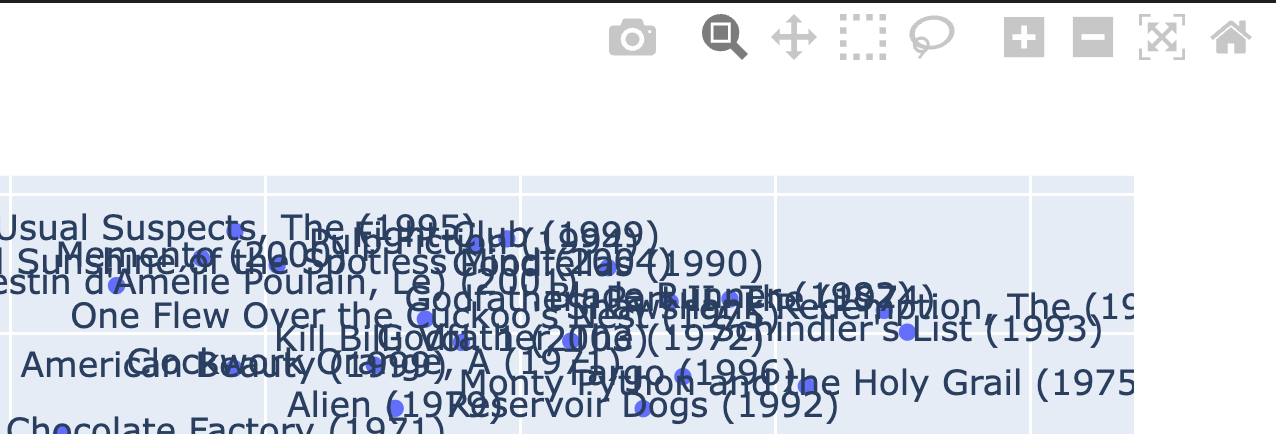

In [ ]:
import plotly.express as px
fig = px.scatter(x=filtered_2d_embs[:,0], y=filtered_2d_embs[:,1], text=list(filtered_titles))
fig.show(renderer="colab")


#### 3D Plot
- You can rotate the camera with left click drag
- You can pan the camera with right click drag
- You can add 3D title annotations by add titles in `highlighted_movie_titles`
  - e.g. `highlighted_movie_titles = ["Titanic (1997)", "Back to the Future (1985)"]`
  - You have to exactly match the title name
    - including year, and upper cases


In [ ]:
highlighted_movie_titles = ["Titanic (1997)", "Back to the Future (1985)", "Spider-Man (2002)", "Batman Begins (2005)"]
make_3d_plot_with_pyplot(filtered_3d_embs,list(filtered_titles), highlighted_titles=highlighted_movie_titles)

## Problem 4: Interpreting Dimension
- The trained embedding space has several dimensions
- Can you explain what kind of characteristics does each dimension represents?
  - For a selcted dimension, try to figure out what is the commonalities between movies with high value in that dimension, and between movies with low value in that dimension
  - Give your explanation or hypothesis that can explain one of the dimensions 
    - e.g. "This dimension seems that it represents 'Casting-Top-Male-Star', because movies with famous male actor had high value"
    - e.g. "This dimension seems that it represents 'Horror film', because horror movies got the high values and movies for children had low values"
  - There is no answer to this question. The trained result can be different based on the number of factors and random seed for the random initialization
    - You don't have to explain all the dimension.
    - Your hypothesis doesn't need to be perfect, that can explains entire tendency
- **You HAVE TO attach the screen capture of top and bottom 10 movies of the selected dimension on the report**
- You can set the print options with `pd.set_option('display.min_rows', 20)`

In [ ]:
selected_dim_idx = 0
movie_embs_tensor = torch.tensor(movie_embs)
_, indices = torch.sort(movie_embs_tensor[:,selected_dim_idx], descending=True)
indices = indices.tolist()
pd.DataFrame({"title": list(movies.iloc[indices]['title']), "Genres": list(movies.iloc[indices]['genres']),  "Value": movie_embs[indices, selected_dim_idx].tolist()})

## Problem 5: Calculate Classification Accuracy (8 pts)
- MSE Loss does not tell how many of your estimations were correct or not
- Complete a code that can calculate the accuracy
  - Let's define that the prediction is accurate if and only if the rounded value of estimation matches with the ground-truth score
    - e.g.: If the estimated rating is 2.4 and the ground-truth rating is 2, it is considered as an accurate (correct) estimation
    - e.g.: If the estimated rating is 3.6 and the ground-truth rating is 3, it is considered as an inaccurate (wrong) estimation
  - For given validation data samples, the `get_accuracy(pred, target)` has to count the number of correct estimation then divide by total number of data sample

- use `atensor.item()` to convert a tensor with single value to a float
- Attach the screen capture of the code in your report

In [ ]:
def get_accuracy(pred,target):
  '''
  pred (torch.Tensor): Estimated ratings of data samples. Shape of [n,1], where n is number of data samples
  target (torch.Tensor): Ground-truth ratings of data samples. Shaoe of [n,1], where n is number of data samples

  The order of data sample for pred and target is same.

  output (float): Number of correct estimations divided by number of data samples

  Hint: You can get the round value for each element of Tensor by torch.round(atensor)
  '''
  # TODO: Complete this function
  return

'''
You don't have to change the code below
'''

dummy_estimation = torch.Tensor([[2.532], [1.672], [3.741], [4.512], [2.701] ])
dummy_target = torch.Tensor([[2], [1], [4], [5], [2] ])
accuracy = get_accuracy(dummy_estimation, dummy_target)

print(f"The accuracy is {accuracy}")

## Problem 6: Estimate the ratings for a user and a movie (8 pts)
- Using the embeddings and biases of user and movie, calculate the estimated rating of the user for the movie
  - Definition of dot product (from [here](https://en.wikipedia.org/wiki/Dot_product))
  - ![dot_product](https://drive.google.com/uc?export=view&id=10mpRKPjK7N8SSw6MQO61slN5GIoQH6Fr)
  - Rating can be estimated by dot product value of user and item embeddings added with user's bias and item's bias
- Attach the screen capture of the code in your report

In [ ]:
def estimates_rating(user_embedding, movie_embedding, user_bias, movie_bias):
  '''
  user_embedding (torch.Tensor): Trained embeddings for a user, in shape of [n_factors]
  user_embedding (torch.Tensor): Trained embeddings for a movie, in shape of [n_factors]
  user_bias (torch.Tensor): Trained bias for a user, in shape of [1]
  movie_bias (torch.Tensor): Trained bias for a user, in shape of [1]

  output (torch.Tensor): Estimated score of the user for the movie
  '''
  # TODO: Complete this function
  # You don't have to consider sigmoid_range for this problem
  # The scaling function will be applied after this function 
  return

selected_user_index = 0
selected_movie_index = 0


'''
You don't have to change the code below
'''

selected_user_emb = model.user_embedding.weight[selected_user_index]
selected_movie_emb = model.movie_embedding.weight[selected_movie_index]
selected_user_bias = model.user_bias.weight[selected_user_index]
selected_movie_bias = model.movie_bias.weight[selected_movie_index]

estimated_rating = estimates_rating(selected_user_emb, selected_movie_emb, selected_user_bias, selected_movie_bias)
estimated_rating = model.scaled_sigmoid(estimated_rating).item()

print(f"Estimated rating of user {selected_user_index} for movie {movies.iloc[selected_movie_index]['title']} is {estimated_rating}")